# Multiband histogram matching with Rasterio and Scikit-image

In [7]:
# import packages
import rasterio as rio
from skimage.exposure import match_histograms

#plot functions
from rasterio.plot import show
from skimage import exposure
import matplotlib.pyplot as plt

In [6]:
!pip install rasterio
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 32.7 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
import rasterio
from rasterio.errors import NotGeoreferencedWarning
import warnings

warnings.filterwarnings('ignore', category=NotGeoreferencedWarning)

def load_image(image_path):
    with rasterio.open(image_path) as src:
        img = src.read()
        transform = src.transform
        crs = src.crs
        if transform == rasterio.transform.Affine.identity():
            transform = None
        if crs is None:
            crs = 'EPSG:4326'  # Default to WGS84 if CRS is not defined
    return img, transform, crs

# Load the 2017 and 2024 images
img_2017, transform_2017, crs_2017 = load_image('/content/drive/My Drive/EarthEngine/Sentinel2_2017.tif')
img_2024, transform_2024, crs_2024 = load_image('/content/drive/My Drive/EarthEngine/Sentinel2_2024.tif')

print(f"2017 Image shape: {img_2017.shape}")
print(f"2024 Image shape: {img_2024.shape}")
print(f"2017 Transform: {transform_2017}, CRS: {crs_2017}")
print(f"2024 Transform: {transform_2024}, CRS: {crs_2024}")


2017 Image shape: (10, 2276, 2346)
2024 Image shape: (10, 2276, 2346)
2017 Transform: | 0.00, 0.00,-77.12|
| 0.00,-0.00, 39.00|
| 0.00, 0.00, 1.00|, CRS: EPSG:4326
2024 Transform: | 0.00, 0.00,-77.12|
| 0.00,-0.00, 39.00|
| 0.00, 0.00, 1.00|, CRS: EPSG:4326


In [30]:
from skimage.exposure import match_histograms

def match_histograms_multiband(source, reference):
    matched = np.zeros_like(source, dtype=np.float32)
    for band in range(source.shape[0]):
        valid_mask_source = ~np.isnan(source[band])
        valid_mask_reference = ~np.isnan(reference[band])

        source_band = source[band][valid_mask_source]
        reference_band = reference[band][valid_mask_reference]

        matched_band = match_histograms(
            source_band, reference_band, multichannel=False)

        matched[band, valid_mask_source] = matched_band
    return matched

# Perform histogram matching
matched_img_2024 = match_histograms_multiband(img_2024, img_2017)
print("Histogram matching completed.")


<ipython-input-30-ca156b31ae1f>:12: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  matched_band = match_histograms(


Histogram matching completed.


In [31]:
matched_img_2024.min()

0.0

In [23]:
import rasterio

def save_image(image, transform, crs, output_path):
    with rasterio.open(output_path, 'w', driver='GTiff', height=image.shape[1], width=image.shape[2], count=image.shape[0], dtype=image.dtype, crs=crs, transform=transform) as dst:
        for band in range(image.shape[0]):
            dst.write(image[band, :, :], band + 1)

# Save the matched 2024 image with correct transform and CRS
save_image(matched_img_2024, transform_2024, crs_2024, '/content/drive/My Drive/EarthEngine/Sentinel2_2024_matched.tif')
print("Matched 2024 image saved.")

Matched 2024 image saved.


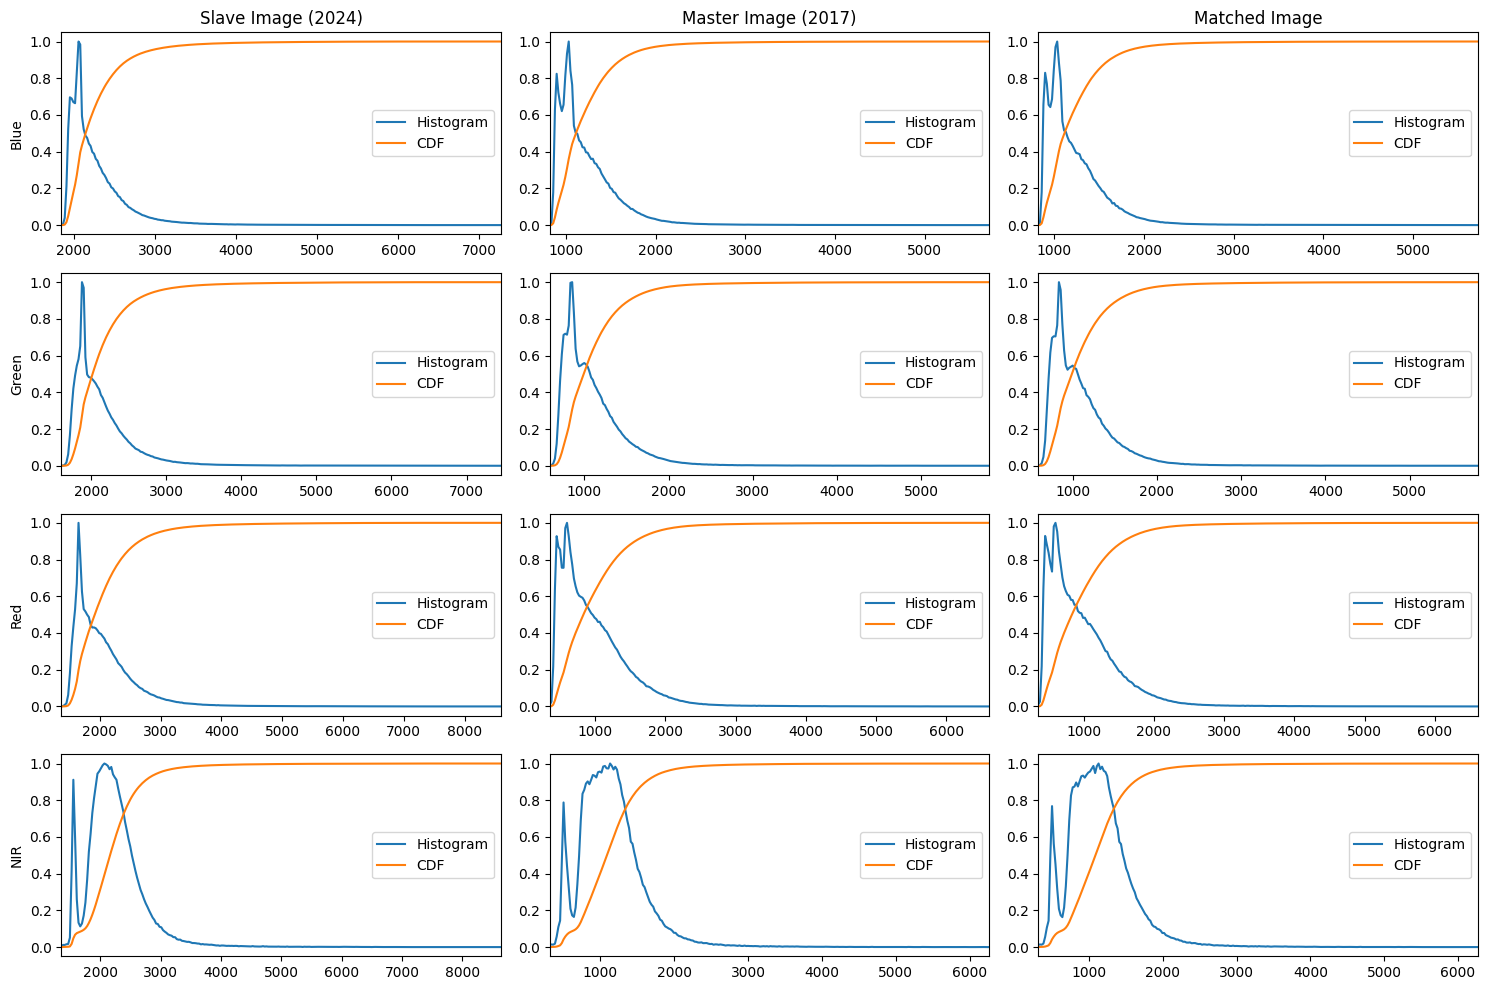

In [24]:
import matplotlib.pyplot as plt
from skimage import exposure

def plot_histograms_and_cdfs(master, slave, matched, band_names):
    fig, axes = plt.subplots(nrows=len(band_names), ncols=3, figsize=(15, 10))

    images = [slave, master, matched]
    titles = ['Slave Image (2024)', 'Master Image (2017)', 'Matched Image']

    for i, img in enumerate(images):
        for c, band_name in enumerate(band_names):
            valid_mask = (img[c] > 0) & ~np.isnan(img[c])  # Exclude zeros and NaNs
            img_band = img[c][valid_mask]

            img_hist, bins = exposure.histogram(img_band)
            img_cdf, bins_cdf = exposure.cumulative_distribution(img_band)

            axes[c, i].plot(bins, img_hist / img_hist.max(), label='Histogram')
            axes[c, i].plot(bins_cdf, img_cdf, label='CDF')
            axes[c, i].set_xlim([bins.min(), bins.max()])
            if i == 0:
                axes[c, i].set_ylabel(band_name)
            if c == 0:
                axes[c, i].set_title(titles[i])

    for ax in axes.flatten():
        ax.legend()

    plt.tight_layout()
    plt.show()

# Define band names
band_names = ['Blue', 'Green', 'Red', 'NIR']

# Plot histograms and CDFs for each band
plot_histograms_and_cdfs(img_2017, img_2024, matched_img_2024, band_names)